In [1]:
import csv
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (16,9)
rcParams['font.size'] = 12
import numpy as np
import scipy as sp
import os 
import glob
import pandas as pd
import seaborn as sns

#pd.set_option("display.max_rows", None, "display.max_columns", None)

data_path = os.getcwd()
data_extension = "csv"

os.chdir(data_path)

In [2]:
result = [file for file in glob.glob("/home/juergen/Desktop/logs_phase1/" + '*.{}'.format(data_extension))]
participants, hashes = result.pop(result.index('/home/juergen/Desktop/logs_phase1/pidList.csv')), result.pop(result.index('/home/juergen/Desktop/logs_phase1/finishedHashes.csv'))

In [3]:
import csv

# omit incomplete data sets

result.sort()
is_missing_header = False

# omit due to missing runs
to_omit = []
to_omit_pids = []
for f in result:
    with open(f, "r") as file:
        reader = csv.reader(file, delimiter=",")
        rids = []

        for i, row in enumerate(reader):
            pid = -1
            
            if i == 0:
                if row != ['timestampLog', 'pid', 'condition_id', 'run_id', 'timestampConditionStart', 'timestampCollision', 'timestampClick', 'mouseIsInsideElement', 'targetX', 'targetY', 'targetWidth', 'targetHeight', 'cursorX', 'cursorY']:
                    is_missing_header = True
            else:
                rids.append(int(row[3]))
                
        rids = list(set(rids))
                
        target_sum = sum([i for i in range(1, 51)]) if 'cooldown' in f or 'warmup' in f else sum([i for i in range(1, 101)])
                
        if sum(rids) != target_sum:
            to_omit.append(f)
        elif is_missing_header:
            pass
            # reconstruct missing header
    
for f in to_omit:
    root = f.split("-")[0]
    
    to_omit_pids.append(root[-1])
    pattern = root + "-"
    
    result = [elem for elem in result if pattern not in elem]    

In [4]:
dff = [(pd.read_csv(f, delimiter = ','), f) for f in result]

concats = {}

for df in dff:
    condition_id = list(df[0]["condition_id"])[0]

    if not condition_id in concats:
        concats[condition_id] = df[0]
    else:
        concats[condition_id] = pd.concat([concats[condition_id], df[0]])
    
        
dff = concats.values()

pids = list(concats[0].pid.unique())

In [5]:
import math

class Run:
    def __init__(self, data):
        self.data = data
                        
        self.condition = list(data["condition_id"])[0]
        
        self.pid = list(data["pid"])[-1]        
        self.run_id = list(data["run_id"])[-1]
        self.run_starttime = list(data["timestampConditionStart"])[0]
        self.successful_click_time = list(data["timestampClick"])[-1]
        
        self.run_duration = float(self.successful_click_time) - float(self.run_starttime)
        self.errors = len(list(data["timestampClick"])) - list(data["timestampClick"]).count("oldval") - 1
              
        ###########################
        self.collisions = 0
        initial_collision_ts = list(data["timestampCollision"])[0]

        for i in list(data["timestampCollision"]):
            if initial_collision_ts != i:
                self.collisions += 1
                initial_collision_ts = i        
        
        ##############################
       
        self.num_cursor_movements = 0
        self.cursor_movement_length = 0
        self.num_target_movements = 0
        self.target_movement_length = 0
        
        initial_cursor_x = int(float(list(data["cursorX"])[0]))
        initial_cursor_y = int(float(list(data["cursorY"])[0]))
        initial_target_x = int(float(list(data["targetX"])[0]))
        initial_target_y = int(float(list(data["targetY"])[0]))
        
        for i in range(0, len(list(data["cursorX"]))):
            x, y = int(float(list(data["cursorX"])[i])), int(float(list(data["cursorY"])[i]))
            tx, ty = int(float(list(data["targetX"])[i])), int(float(list(data["targetY"])[i]))
            
            if x != initial_cursor_x or y != initial_cursor_y:
                self.cursor_movement_length += self.vector_length(x - initial_cursor_x, y - initial_cursor_y)
                self.num_cursor_movements += 1
                initial_cursor_x = x
                initial_cursor_y = y
                
            if tx != initial_target_x or ty != initial_target_y:
                self.num_target_movements += 1
                self.target_movement_length += self.vector_length(tx - initial_target_x, ty - initial_target_y)
                initial_target_x = tx
                initial_target_y = ty
              
    def __repr__(self):
        return "condition:{0}\npid: {1}\nrun_id: {2}\ncollisions:{3}\nerrors:{4}\nduration:{5} ms\ncursor movements:{6}\ncursor movement length:{7}\ntarget movements:{8}\ntarget movement length:{9}\n\n".format(
            self.condition,
            self.pid,
            self.run_id,
            self.collisions,
            self.errors,
            self.run_duration,
            self.num_cursor_movements,
            self.cursor_movement_length,
            self.num_target_movements,
            self.target_movement_length)
    
    def vector_length(self, u, v):
        return math.sqrt(u * u + v * v)
    

In [6]:
conditions = []

for df in dff:
    conditions.append([])
    
    for pid in pids:
        dfp = df[df["pid"] == pid]
        
        for rid in range(1, max(df["run_id"])):
            dfpr = dfp[dfp["run_id"] == rid]
            conditions[-1].append(Run(dfpr))

# Results

## Demographics

In [7]:
def range_mean_median_sd(label, data):
    data = [i if i == i and i != '-' else 0 for i in data]
    
    min_data = min(data)
    max_data = max(data)
    mean_data = np.mean(data)
    median_data = np.median(data)
    sd_data = sp.stats.tstd(data)

    print("{0} ranges from {1:.2f} to {2:.2f} with a mean of {3:.2f} (sd. {4:.2f}) and median of {5:.2f}".format(label, min_data, max_data, mean_data, sd_data, median_data))

def occurence_dictionary(data):    
    ret = {}
    
    for i in list(data):    
        if i != i or i == '-':
            i = 'unpspecified'
            
        ret[i.lower().rstrip()] = ret.get(i.lower().rstrip(), 0) + 1
        
    return ret

pdf = pd.read_csv(participants, delimiter = ',')
pdf = pdf[pdf.hasFinished != 0]

for pid in to_omit_pids:
    pdf = pdf[pdf.ID != int(pid)]

### Gender

In [8]:
gender = list(pdf["Geschlecht"])
m, w, d = gender.count("Männlich"), gender.count("Weiblich"), gender.count("Divers")
o = len(gender) - (m + w + d)

print("n = {0}".format(len(gender)))
print("{0} male, {1} female, {2} diverse, {3} other".format(m, w, d, o))

n = 2
2 male, 0 female, 0 diverse, 0 other


### Age

In [9]:
ages = list(pdf["Alter"])
range_mean_median_sd("Age", ages)

Age ranges from 20.00 to 21.00 with a mean of 20.50 (sd. 0.71) and median of 20.50


### Occupation

In [10]:
occupations = occurence_dictionary(pdf["Beruf"])
print(occupations)

{'student': 2}


## Duration

Static UI ranges from 364.66 to 1068.33 with a mean of 575.84 (sd. 132.46) and median of 534.10

Factor 0.25 MUI ranges from 390.76 to 1558.21 with a mean of 578.76 (sd. 158.76) and median of 522.36

Factor 0.5 MUI ranges from 376.80 to 1382.17 with a mean of 571.58 (sd. 153.85) and median of 516.09

Factor 0.75 MUI ranges from 367.70 to 1321.93 with a mean of 557.55 (sd. 151.68) and median of 495.98

Factor 1.0 MUI ranges from 372.59 to 1245.00 with a mean of 567.98 (sd. 152.17) and median of 507.42

Static UI with 1.5x CD Gain ranges from 380.25 to 2095.34 with a mean of 623.60 (sd. 219.70) and median of 537.48

Cooldown ranges from 372.16 to 1231.71 with a mean of 588.79 (sd. 166.38) and median of 514.87

Warmup ranges from 411.53 to 1755.50 with a mean of 588.87 (sd. 180.51) and median of 528.24



([<matplotlib.axis.XTick at 0x7fbbdc4e6b50>,
 [Text(1, 0, 'Static UI'),
  Text(2, 0, 'Factor 0.25 MUI'),
  Text(3, 0, 'Factor 0.5 MUI'),
  Text(4, 0, 'Factor 0.75 MUI'),
  Text(5, 0, 'Factor 1.0 MUI'),
  Text(6, 0, 'Static UI with 1.5x CD Gain')])

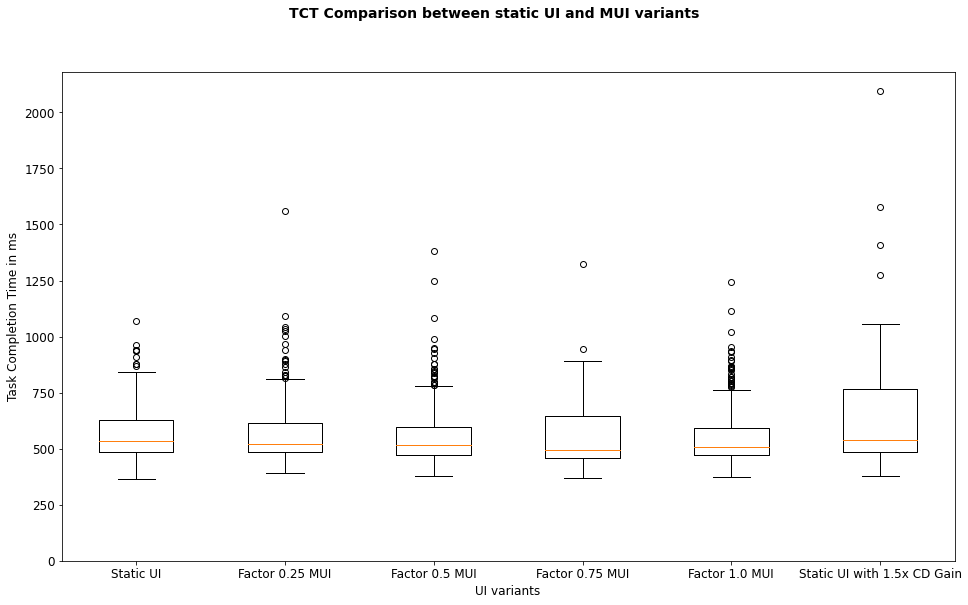

In [11]:
durations = {}

for condition in conditions:
    durations[condition[0].condition] = [run.run_duration for run in condition]
        
ticks = []
data = []

for condition, duration_measurements in durations.items(): 
    cond_name = "Warmup" if condition == -1 else "Static UI" if condition == 0 else "Factor 0.25 MUI" if condition == 1 else "Factor 0.5 MUI" if condition == 2 else "Factor 0.75 MUI" if condition == 3 else "Factor 1.0 MUI" if condition == 4  else "Static UI with 1.5x CD Gain" if condition == 5 else "Cooldown"
    
    range_mean_median_sd (cond_name, duration_measurements)
    print()
    
    if cond_name != "Warmup" and cond_name != "Cooldown":
        data.append(duration_measurements)
        ticks.append(cond_name)

fig = plt.figure()
fig.suptitle('TCT Comparison between static UI and MUI variants', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xlabel('UI variants')
ax.set_ylabel('Task Completion Time in ms')
ax.set_ylim(bottom=0)
xticks([i + 1 for i in range(len(ticks))], ticks)


In [12]:
from scipy.stats import ttest_rel as ttest

static_durations = durations[0]
factor025_durations = durations[1]
factor05_durations = durations[2]
factor075_durations = durations[3]
factor1_durations = durations[4]
static15cdg_durations = durations[5]

def getConditionName(cond):
    cond_name = "Static UI" if cond == 0 else "Factor 0.25 MUI" if cond == 1 else "Factor 0.5 MUI" if cond == 2 else "Factor 0.75 MUI" if cond == 3 else "Factor 1.0 MUI" if cond == 4  else "Static UI with 1.5x CD Gain"
    return cond_name
    
for cond in range(6):
    cond_name = getConditionName(cond)
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> p = {}".format(ttest(durations[cond], durations[condToCompare])[1]))
    print()

Static UI vs Factor 0.25 MUI -> p = 0.8443031634534002
Static UI vs Factor 0.5 MUI -> p = 0.7640442385973302
Static UI vs Factor 0.75 MUI -> p = 0.19153915319277923
Static UI vs Factor 1.0 MUI -> p = 0.5701307945160234
Static UI vs Static UI with 1.5x CD Gain -> p = 0.00878348092576342

Factor 0.25 MUI vs Static UI -> p = 0.8443031634534002
Factor 0.25 MUI vs Factor 0.5 MUI -> p = 0.6292145455878582
Factor 0.25 MUI vs Factor 0.75 MUI -> p = 0.17496572607961874
Factor 0.25 MUI vs Factor 1.0 MUI -> p = 0.4902363124472945
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> p = 0.018797916275356232

Factor 0.5 MUI vs Static UI -> p = 0.7640442385973302
Factor 0.5 MUI vs Factor 0.25 MUI -> p = 0.6292145455878582
Factor 0.5 MUI vs Factor 0.75 MUI -> p = 0.35784349143781014
Factor 0.5 MUI vs Factor 1.0 MUI -> p = 0.8153828766023699
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> p = 0.0027503283874022143

Factor 0.75 MUI vs Static UI -> p = 0.19153915319277923
Factor 0.75 MUI vs Factor 0.25 MU

### Warmup vs. Cooldown

Static UI ranges from 364.66 to 1068.33 with a mean of 575.84 (sd. 132.46) and median of 534.10

Factor 0.25 MUI ranges from 390.76 to 1558.21 with a mean of 578.76 (sd. 158.76) and median of 522.36

Factor 0.5 MUI ranges from 376.80 to 1382.17 with a mean of 571.58 (sd. 153.85) and median of 516.09

Factor 0.75 MUI ranges from 367.70 to 1321.93 with a mean of 557.55 (sd. 151.68) and median of 495.98

Factor 1.0 MUI ranges from 372.59 to 1245.00 with a mean of 567.98 (sd. 152.17) and median of 507.42

Static UI with 1.5x CD Gain ranges from 380.25 to 2095.34 with a mean of 623.60 (sd. 219.70) and median of 537.48

Cooldown ranges from 372.16 to 1231.71 with a mean of 588.79 (sd. 166.38) and median of 514.87

Warmup ranges from 411.53 to 1755.50 with a mean of 588.87 (sd. 180.51) and median of 528.24



([<matplotlib.axis.XTick at 0x7fbbdc3e2fa0>,
 [Text(1, 0, 'Cooldown'), Text(2, 0, 'Warmup')])

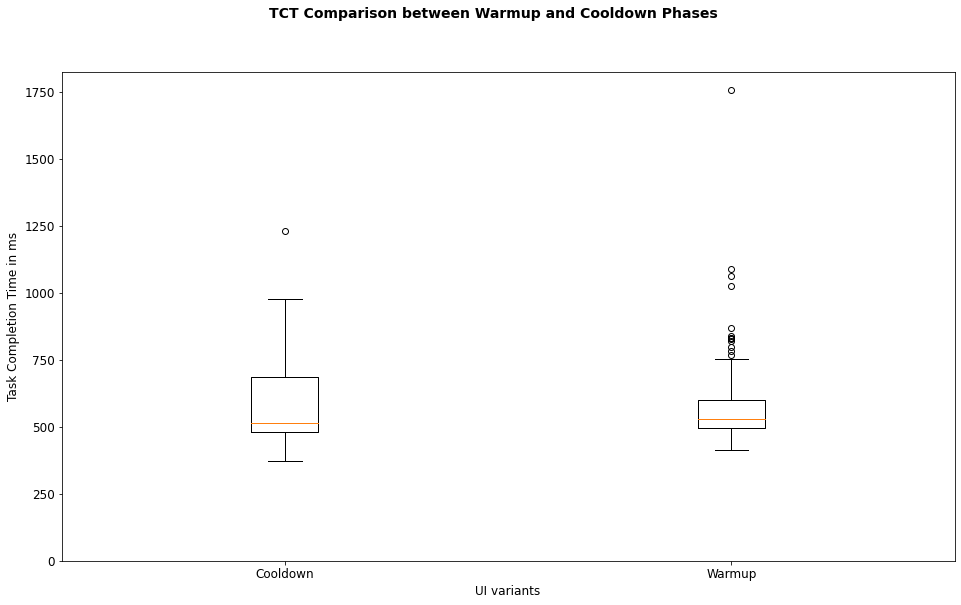

In [13]:
durations = {}

for condition in conditions:
    durations[condition[0].condition] = [run.run_duration for run in condition]
        
ticks = []
data = []

for condition, duration_measurements in durations.items(): 
    cond_name = "Warmup" if condition == -1 else "Static UI" if condition == 0 else "Factor 0.25 MUI" if condition == 1 else "Factor 0.5 MUI" if condition == 2 else "Factor 0.75 MUI" if condition == 3 else "Factor 1.0 MUI" if condition == 4  else "Static UI with 1.5x CD Gain" if condition == 5 else "Cooldown"
    
    range_mean_median_sd (cond_name, duration_measurements)
    print()
    
    if cond_name == "Warmup" or cond_name == "Cooldown":
        data.append(duration_measurements)
        ticks.append(cond_name)

fig = plt.figure()
fig.suptitle('TCT Comparison between Warmup and Cooldown Phases', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)
ax.set_xlabel('UI variants')
ax.set_ylabel('Task Completion Time in ms')
ax.set_ylim(bottom=0)
xticks([i + 1 for i in range(len(ticks))], ticks)

In [14]:
from scipy.stats import ttest_rel as ttest

warmup = []
cooldown = []
for condition, duration_measurements in durations.items():         
    if condition == -1:
        warmup = duration_measurements
        
    if condition == 6:
        cooldown = duration_measurements
        
p = ttest(warmup, cooldown)[1]

print("Warmup" + " vs " + "Cooldown" + " -> p = {:.5f}".format(p))

Warmup vs Cooldown -> p = 0.99743


## Errors

In [15]:
def increase_in_percent(counter, denominator):
    return (counter / (denominator / 100)) - 100

errors = {}

for condition in conditions:
    errors[condition[0].condition] = sum([run.errors for run in condition])

for cond in range(6):
    cond_name = getConditionName(cond)
    print("Errors for " + cond_name + ": {}".format(errors[cond]))
    for condToCompare in range(6):
        if cond != condToCompare:
            condToCompare_name = getConditionName(condToCompare)
            print(cond_name + " vs " + condToCompare_name + " -> {:.2f}%".format(increase_in_percent(errors[cond], errors[condToCompare])))
    print("")

Errors for Static UI: 32
Static UI vs Factor 0.25 MUI -> -5.88%
Static UI vs Factor 0.5 MUI -> -8.57%
Static UI vs Factor 0.75 MUI -> -23.81%
Static UI vs Factor 1.0 MUI -> -20.00%
Static UI vs Static UI with 1.5x CD Gain -> -45.76%

Errors for Factor 0.25 MUI: 34
Factor 0.25 MUI vs Static UI -> 6.25%
Factor 0.25 MUI vs Factor 0.5 MUI -> -2.86%
Factor 0.25 MUI vs Factor 0.75 MUI -> -19.05%
Factor 0.25 MUI vs Factor 1.0 MUI -> -15.00%
Factor 0.25 MUI vs Static UI with 1.5x CD Gain -> -42.37%

Errors for Factor 0.5 MUI: 35
Factor 0.5 MUI vs Static UI -> 9.38%
Factor 0.5 MUI vs Factor 0.25 MUI -> 2.94%
Factor 0.5 MUI vs Factor 0.75 MUI -> -16.67%
Factor 0.5 MUI vs Factor 1.0 MUI -> -12.50%
Factor 0.5 MUI vs Static UI with 1.5x CD Gain -> -40.68%

Errors for Factor 0.75 MUI: 42
Factor 0.75 MUI vs Static UI -> 31.25%
Factor 0.75 MUI vs Factor 0.25 MUI -> 23.53%
Factor 0.75 MUI vs Factor 0.5 MUI -> 20.00%
Factor 0.75 MUI vs Factor 1.0 MUI -> 5.00%
Factor 0.75 MUI vs Static UI with 1.5x CD Ga

## Covered Distances

In [16]:
# covered_distance
mean_covered_distances_cursor = {}

for condition in conditions:
    mean_covered_distances_cursor[condition[0].condition] = sum([run.cursor_movement_length for run in condition]) / len([run.cursor_movement_length for run in condition])

In [17]:
static_mean_covered_distance = mean_covered_distances_cursor[0]
factor05_mean_covered_distance = mean_covered_distances_cursor[1]
factor1_mean_covered_distance = mean_covered_distances_cursor[2]
static15cdg_mean_covered_distance = mean_covered_distances_cursor[3]


for cond in range(6):
    cond_name = getConditionName(cond)
    print("Mean covered distance of cursor for " + cond_name + ": {}px".format(mean_covered_distances_cursor[cond]))

Mean covered distance of cursor for Static UI: 392.3945854428766px
Mean covered distance of cursor for Factor 0.25 MUI: 370.2315172964634px
Mean covered distance of cursor for Factor 0.5 MUI: 274.00532128149086px
Mean covered distance of cursor for Factor 0.75 MUI: 315.9883902056846px
Mean covered distance of cursor for Factor 1.0 MUI: 254.34109454330763px
Mean covered distance of cursor for Static UI with 1.5x CD Gain: 413.6839765256355px


## Most notable observation

WIP